# Self-Driving Car Engineer 
## Lucas Gago

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier



---
## Step 0: Load The Data

In [19]:
# Libraries:
import os
from urllib.request import urlretrieve
from os.path import isfile
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
import math
%matplotlib inline
import numpy as np
from collections import Counter
import tensorflow as tf
from sklearn.utils import shuffle
from tensorflow.contrib.layers import flatten
import cv2
from sklearn.cross_validation import train_test_split
import pandas as pd

In [2]:
#Download the dataset

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile('train.p'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='Train Dataset') as pbar:
        urlretrieve(
            'https://s3.amazonaws.com/udacity-sdc/datasets/german_traffic_sign_benchmark/train.p',
            'train.p',
            pbar.hook)

if not isfile('test.p'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='Test Dataset') as pbar:
        urlretrieve(
            'https://s3.amazonaws.com/udacity-sdc/datasets/german_traffic_sign_benchmark/test.p',
            'test.p',
            pbar.hook)

print('Training and Test data downloaded.')

Training and Test data downloaded.


In [3]:
# Load pickled data

training_file = "train.p"
testing_file = "test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)

with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
train_features, train_labels = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**



In [4]:
n_train = len(train_features)
n_test = len(X_test)
image_shape = X_test[0].shape
n_classes = len(set(train_labels))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


In [5]:
data_test = [[i,sum(y_test == i)] for i in range(len(np.unique(y_test)))]
data_test_sorted = sorted(data_test, key=lambda x: x[1])
data_train = [[i,sum(train_labels == i)] for i in range(len(np.unique(train_labels)))]
data_train_sorted = sorted(data_train, key=lambda x: x[1])
data_pd = pd.read_csv('signnames.csv')
data_pd['Occurance (Train)'] = pd.Series(np.asarray(data_train_sorted).T[1], index=np.asarray(data_train_sorted).T[0])
data_pd['Occurance (Test)'] = pd.Series(np.asarray(data_test_sorted).T[1], index=np.asarray(data_test_sorted).T[0])

data_pd_sorted = data_pd.sort_values(['Occurance (Train)'],ascending=[0]).reset_index()
data_pd_sorted = data_pd_sorted.drop('index', 1)

In [6]:
data_pd_sorted.head()

,ClassId,SignName,Occurance (Train),Occurance (Test)
0,2,Speed limit (50km/h),2250,750
1,1,Speed limit (30km/h),2220,720
2,13,Yield,2160,720
3,12,Priority road,2100,690
4,38,Keep right,2070,690


In [7]:
data_pd_sorted.tail()

,ClassId,SignName,Occurance (Train),Occurance (Test)
38,32,End of all speed and passing limits,240,60
39,27,Pedestrians,240,60
40,37,Go straight or left,210,60
41,19,Dangerous curve to the left,210,60
42,0,Speed limit (20km/h),210,60


### Visualization of the dataset

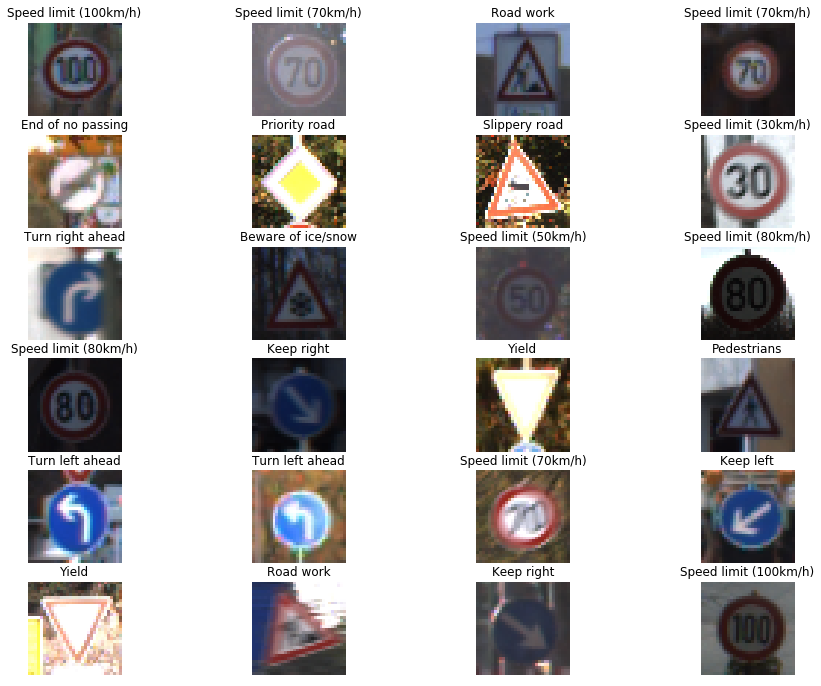

In [38]:
def showGrid(h,w,X,Y):
    plt.figure(figsize = (16,12))
    gs1 = gridspec.GridSpec(h,w)
    gs1.update(wspace=0.02, hspace=0.2) # set the spacing between axes. 
    for i in range(h*w):
        ax1 = plt.subplot(gs1[i])
        plt.axis('on')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        ax1.set_aspect('equal')
        ind_plot = np.random.randint(1,len(Y))
        plt.imshow(X[ind_plot])
        sign_number=(Y[ind_plot])
        plt.title(data_pd.iloc[sign_number].SignName)
        plt.axis('off')
    plt.show()
    

showGrid(6,4,train_features,train_labels)

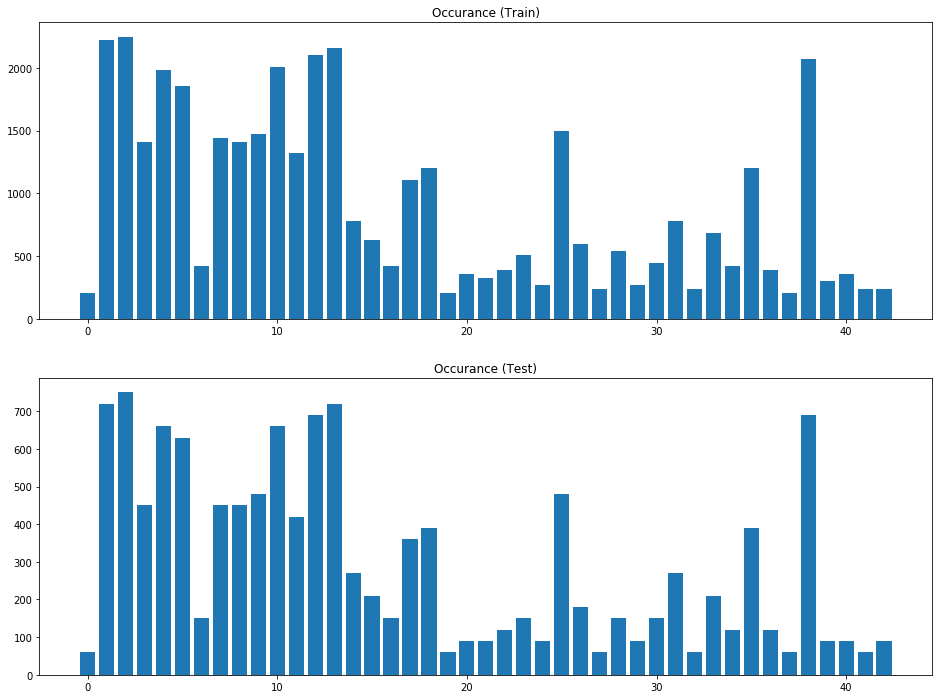

In [9]:
plt.figure(figsize=(16,12))
plt.subplot(212)
plt.bar(range(43),height=data_pd["Occurance (Test)"])
plt.title("Occurance (Test)")

plt.subplot(211)
plt.bar(range(43),height=data_pd["Occurance (Train)"])
plt.title("Occurance (Train)")
plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implementation of a deep learning model that learns to recognize traffic signs. Trained and tested on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). 


### Pre-process the Data Set 

In [12]:
%%time

#Random bright

new=[]
for feature in train_features:
    #feature = cv2.cvtColor(feature, cv2.COLOR_BGR2YUV)
    # equalize the histogram of the Y channel
    #feature[:,:,0] = cv2.equalizeHist(feature[:,:,0])
    # convert the YUV image back to RGB format
    #feature = cv2.cvtColor(feature, cv2.COLOR_YUV2BGR)
    rnd_number=np.random.uniform()
    image1 = cv2.cvtColor(feature,cv2.COLOR_BGR2HSV)
    random_bright = .25+rnd_number
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2BGR)
    kernel = np.ones((3,3),np.float32)/9
    #image1 = cv2.filter2D(image1,-1,kernel)
    new.append(image1)
train_features_arg=np.concatenate((train_features,new),axis=0)
print(len(train_labels))
train_labels_arg=np.concatenate((train_labels,train_labels),axis=0)
print(len(train_labels_arg))


39209
78418
Wall time: 1.7 s


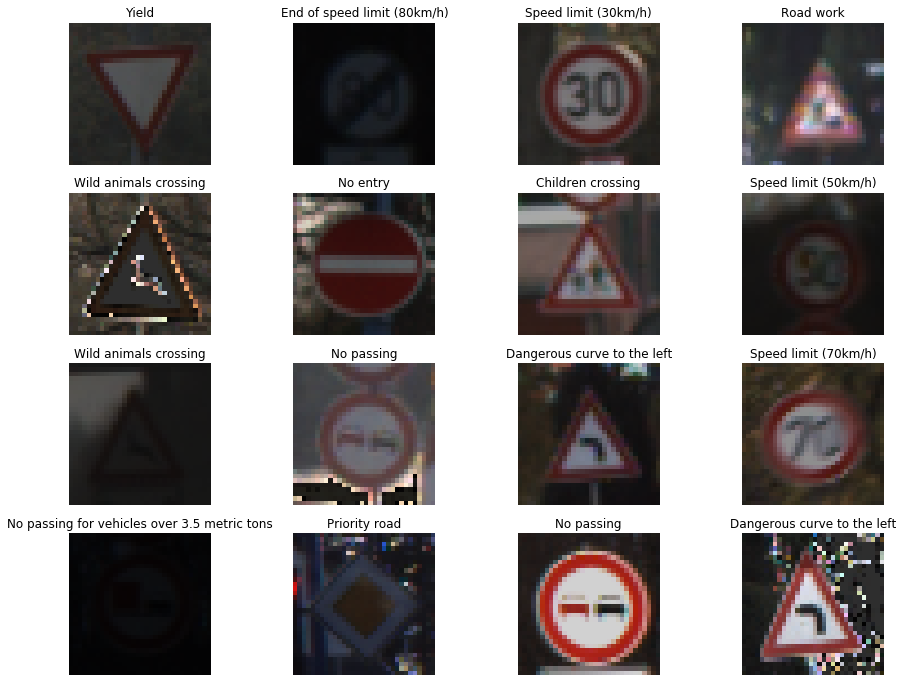

In [13]:
showGrid(4,4,new,train_labels)

In [14]:
X_train=train_features_arg
y_train=train_labels_arg

In [15]:
# Normalize between -1 and 1
X_train=np.array(X_train)
X_train = X_train.astype('float32')
X_train = (X_train - 128.) / 128.
X_test = X_test.astype('float32')
X_test  = (X_test  - 128.) / 128.

In [16]:
X_train, y_train = shuffle(X_train, y_train)
print("Data shuffled")
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=.15)
print("Validation ready")

Data shuffled
Validation ready


### Model Architecture

In [15]:
EPOCHS = 1000
BATCH_SIZE = 124
LEARNING_RATE= .001
BETA=1e-5
DROPOUT_KEEP=.5

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the test set but low accuracy on the validation set implies overfitting.

In [16]:
def LeNet(x,keep_prob):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    fc1 = tf.nn.dropout(fc1, keep_prob)
    
    # Activation.
    fc1    = tf.nn.relu(fc1)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)

    # Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    # L2 Regularization
    l2_loss= (tf.nn.l2_loss(conv1_W)+tf.nn.l2_loss(conv2_W)+tf.nn.l2_loss(fc2_W)+tf.nn.l2_loss(fc1_W)+tf.nn.l2_loss(fc3_W))
    
    return logits,l2_loss

In [17]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, 43)

In [18]:
logits,l2 = LeNet(x,keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)+BETA*l2
optimizer = tf.train.AdamOptimizer(learning_rate = LEARNING_RATE)
training_operation = optimizer.minimize(loss_operation)

In [ ]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y,keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [ ]:
%%time
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y,keep_prob:DROPOUT_KEEP})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        if (i+1)%5==0:
            if (i+1)%50==0:
                saver.save(sess, './lenet2')
                print(" ######## Model saved ######## ")
                print()
            print("EPOCH {} ...".format(i+1))
            print("Validation Accuracy = {:.4f}".format(validation_accuracy))
            test_accuracy = evaluate(X_test, y_test)
            print("Test Accuracy = {:.4f}".format(test_accuracy))
            print()

    saver.save(sess, './lenet2')
    print("Model saved")

Training...



In [ ]:
with tf.Session() as sess:
    saver.restore(sess, save_path='./lenet')
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.4f}".format(test_accuracy))

---

## Step 3: Model  Test on New Images



### Load and Output the Images

In [79]:
def read_image(directoy):
    image = cv2.imread(directoy)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    return image

def process_image(image):
    image = cv2.resize(image,(32,32))
    image = (image-128)/128
    return image


def showGrid(h,w,X,Y):
    plt.figure(figsize = (16,12))
    gs1 = gridspec.GridSpec(h,w)
    gs1.update(wspace=0.02, hspace=0.2) # set the spacing between axes. 
    for i in range(h*w):
        ax1 = plt.subplot(gs1[i])
        plt.axis('on')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        ax1.set_aspect('equal')
        plt.imshow(X[i])
        plt.title(Y[i])
        plt.axis('off')
    plt.show()



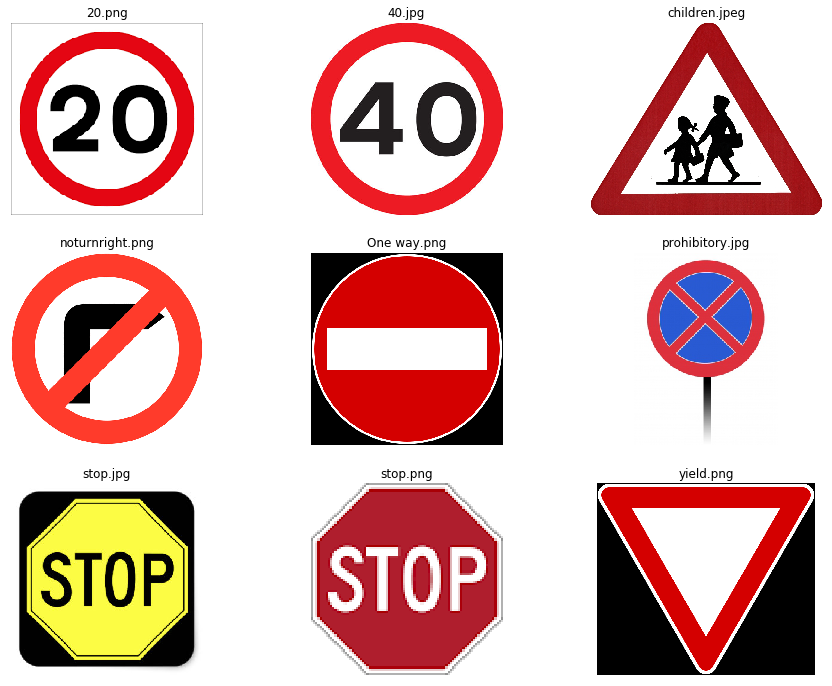

In [95]:
names = [name for name in os.listdir("./images/")]
newdata = [read_image("./images/"+name) for name in names]
newdata_processed=[process_image(img) for img in newdata]
newdata_processed = np.array(newdata_processed ,dtype = np.float32)
showGrid(3,3,(newdata),names)

### Predict the Sign Type for Each Image

In [ ]:
labels_pred = tf.nn.softmax(logits)
feed_dict_new = {features:newdata,keep_prob: 1}
top5 = tf.nn.top_k(labels_pred, 5)

predictions = session.run(labels_pred,feed_dict = feed_dict_new)
top5_pred = session.run([labels_pred, top5], feed_dict=feed_dict_new)

### Analyze Performance

In [ ]:
for i in range(len(newdata_processed)):
    plt.figure(figsize = (5,1.5))
    gs = gridspec.GridSpec(1, 2,width_ratios=[2,3])
    plt.subplot(gs[0])
    plt.imshow(newdata[i]+.5)
    plt.axis('off')
    plt.subplot(gs[1])
    plt.barh(6-np.arange(5),top5_pred[1][0][i], align='center')
    for i_label in range(5):
        plt.text(top5_pred[1][0][i][i_label]+.02,6-i_label-.25,
            data_pd['SignName'][top5_pred[1][1][i][i_label]])
    plt.axis('off');
    plt.text(0,6.95,namenewdata[i].split('.')[0]);
    plt.show();

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [ ]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the IPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 